ZB

https://github.com/Zak-Basso/CNN-Cancer-Detection-Kaggle-Mini-Project

In [1]:
import numpy as np
import os
import cv2
import pandas as pd
from matplotlib import pyplot as plt


In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 1.
The problem is to predict a label withing the test images that identifies that there is at least one pixel of tumor within the 32x32 region in the center of the images.

The data set includes 220,025 train images and 57,458 test images. Each image is 96x96x3 with the inner 32x32 being the target area. The set is taken from the PatchCamelyon benchmark dataset, there are no duplicates

In [3]:
labels = pd.read_csv('data/train_labels.csv')
ytrain = labels['label']
Xtrain = []

# for filename in labels['id']:
#     img = cv2.imread('data/train/' + filename + '.tif', cv2.IMREAD_UNCHANGED)
#     if img is not None:
#         Xtrain.append(img)
# #
for filename in labels['id']:
    img = cv2.imread('data/train/' + filename + '.tif', cv2.IMREAD_UNCHANGED)
    if img is not None:
        Xtrain.append(img[31:65,31:65,:])

In [4]:
Xtest = []
Xtest_ids = []

# for filename in os.listdir('data/test'):
#     image_path = os.path.join('data/test', filename)
#     img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
#     if img is not None:
#         Xtest.append(img)
#         Xtest_ids.append(filename)
#
for filename in os.listdir('data/test'):
    image_path = os.path.join('data/test', filename)
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if img is not None:
        Xtest.append(img[31:65,31:65,:])
        Xtest_ids.append(filename)

In [5]:
Xtrain = np.array(Xtrain)
Xtest = np.array(Xtest)
Xtrain_ = Xtrain.astype('float32')/255.0
Xtest_ = Xtest.astype('float32')/255.0
print(Xtrain_.shape,len(ytrain), Xtest.shape)
print(ytrain[:3])

(220025, 34, 34, 3) 220025 (57458, 34, 34, 3)
0    0
1    1
2    0
Name: label, dtype: int64


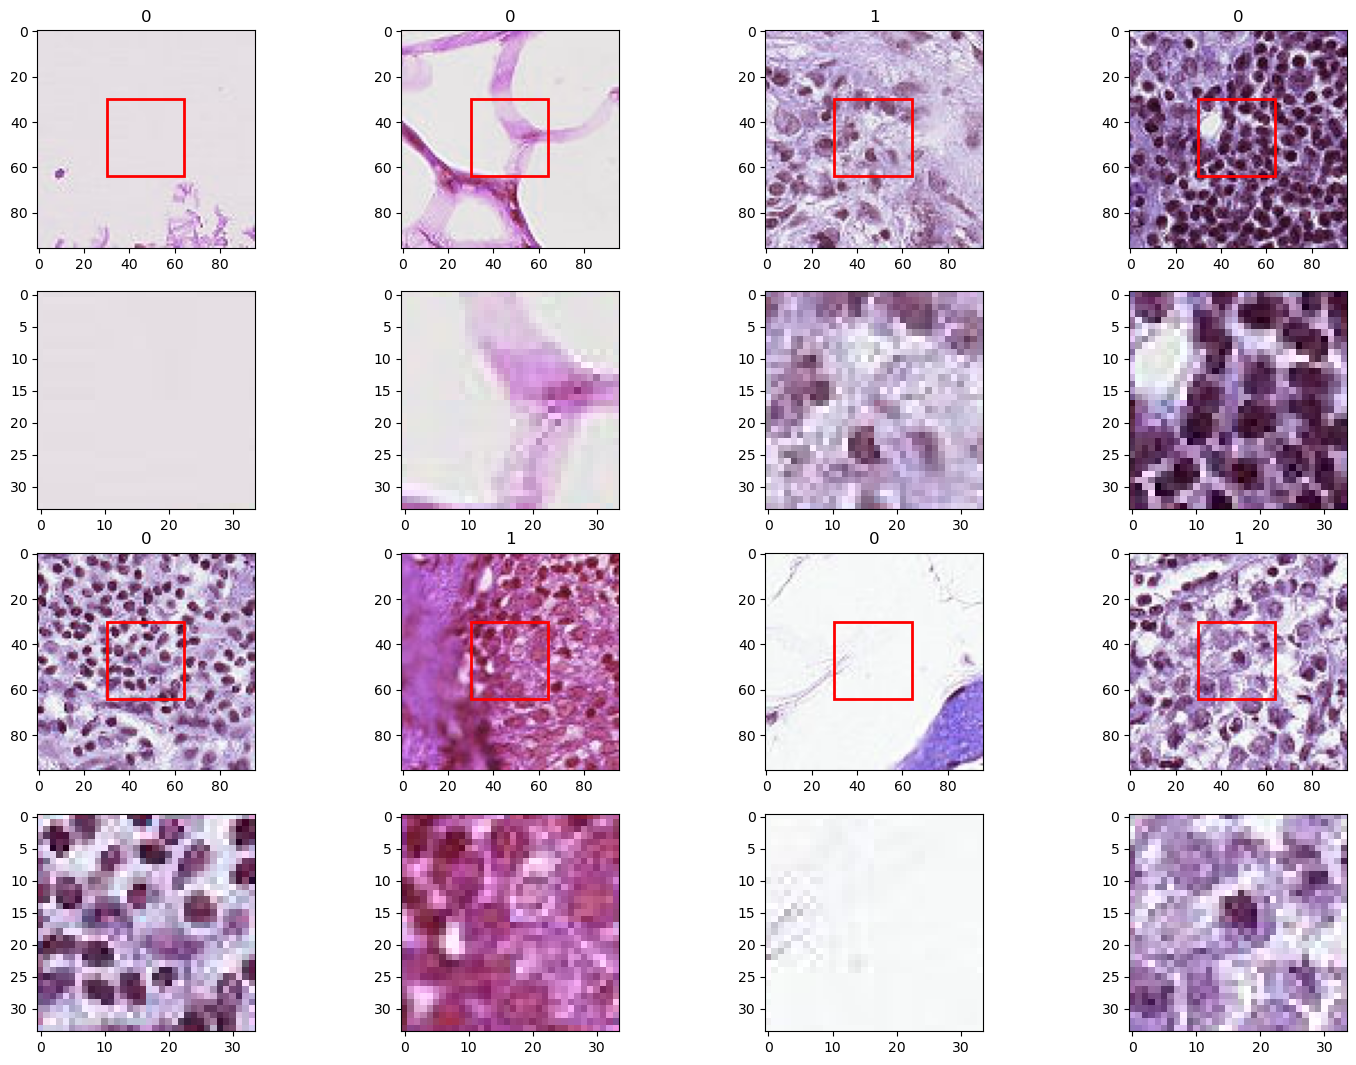

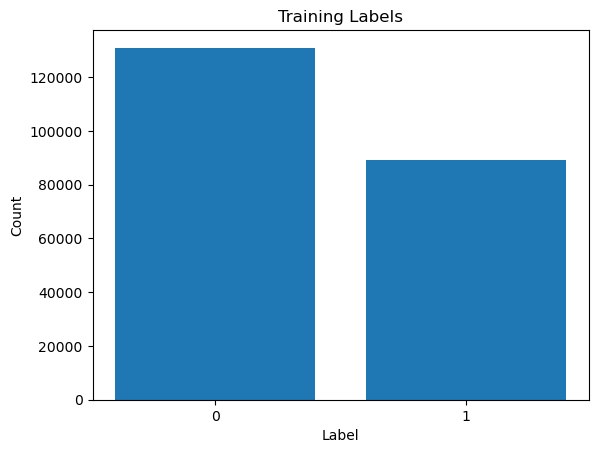

In [6]:
from matplotlib import patches
fig, axes = plt.subplots(4,4, figsize=(18,13))
axes = axes.flatten()
for j in range(2):
    for i in range(4):
        ax = axes[8*j+i]
        ax.imshow(cv2.imread('data/train/' + labels['id'][(j*4)+i+12] + '.tif', cv2.IMREAD_UNCHANGED))
        rect = patches.Rectangle(
            (30, 30),
            34,
            34,
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)
        ax.set_title(ytrain[(j*4)+i+12])
        ax = axes[8*j+i+4]
        ax.imshow(Xtrain_[(j*4)+i+12])

plt.show()

plt.bar([0,1],[len(ytrain)-sum(ytrain),sum(ytrain)],align='center')
plt.xticks([0,1])
plt.title('Training Labels')
plt.ylabel('Count')
plt.xlabel('Label')
plt.show()


### 2.
The data as provided was in good condition, therefore the only cleaning operation I took was to convert the pixel values from int 0-255 to float 0-1.0 to insure stability of whichever optimization process I use. Another preprocessing step I took was to crop the images to their center 32x32 target area allowing me to focus on the part of image that contained the labeled pixels as well as to reduce the parameter count and keep memory and compute in check.

The training data was split  ~60/40 - Negative/Positive which only constitutes a slight imbalance that I don't see affecting my output.

I want to try to build a classification model that can generalize well because the small images cause it to overfit quite easily.
I plan to start with convolutional (Conv2D + MaxPool2D) layers along with at least one dense hidden layer and a sigmoid output layer to classify. Following the general trend of VGGNet.

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Input, Dropout, RandomFlip, RandomRotation, Conv3D
from keras import regularizers

model = Sequential([
    Input(shape=(34, 34, 3)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    MaxPool2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    MaxPool2D(pool_size=(2, 2)),

    # Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    Dropout(0.2),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                    

In [14]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
model.compile(loss='binary_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='auto')

### 3.
I followed the basic VGG style blocks to create my architecture, I think this is suitable for the image classification problem provided.

Input: (34, 34, 3), I used 1 extra pixel on each side to allow for the first conv layer to see just outside the target.

Block 1: Conv x2, MaxPool, (15, 15, 64), Following the VGGNet I stacked two 64 filter Conv2D layers to try and learn low level features. And MaxPooling to reduce my spacial dimension. ~39k params

Block 2: Conv x2, MaxPool, (5, 5, 128), Two 128 filter Conv2D layers to learn more complex features. ~ 220k params

Dropout: 0.2, Low rate dropout to prove some regulization on the features without discarding too much.

Flatten: (3200,), Convert for classification

Dense: (256,), Dense layer for classification. ~820k params

Dense: (128,), Second dense layer. ~ 32k params

Dropout: .5, Strong dropout applied to the dense layers to combat overfitting that was present.

Dense: (1,), Final 0-1 output

Total params: 1,112,641

L2 Reg(.001) applied to conv and dense layers to try to penalize the memorization that was very present in the image set.

Architectures I tried before using this general form had extreme overfitting issues that led to some of the high 90 train accuracy while having <70 test accuracy. As well as the final model being relatively non-complex which allowed me to run it quickly and without errors.

In [9]:
model.fit(Xtrain_, ytrain, batch_size=64, epochs=50, validation_split=.2, callbacks=[early_stop, lr_schedule])

Epoch 1/50
2751/2751 [==============================] - 38s 12ms/step - loss: 1.4745 - auc: 0.7289 - val_loss: 1.3421 - val_auc: 0.8234 - lr: 0.0100
Epoch 2/50
2751/2751 [==============================] - 33s 12ms/step - loss: 1.2967 - auc: 0.8219 - val_loss: 1.2264 - val_auc: 0.8446 - lr: 0.0100
Epoch 3/50
2751/2751 [==============================] - 33s 12ms/step - loss: 1.1940 - auc: 0.8390 - val_loss: 1.2692 - val_auc: 0.8319 - lr: 0.0100
Epoch 4/50
2751/2751 [==============================] - 33s 12ms/step - loss: 1.1118 - auc: 0.8464 - val_loss: 1.0770 - val_auc: 0.8576 - lr: 0.0100
Epoch 5/50
2751/2751 [==============================] - 33s 12ms/step - loss: 1.0406 - auc: 0.8512 - val_loss: 1.1571 - val_auc: 0.8389 - lr: 0.0100
Epoch 6/50
2751/2751 [==============================] - 33s 12ms/step - loss: 0.9776 - auc: 0.8552 - val_loss: 0.9560 - val_auc: 0.8670 - lr: 0.0100
Epoch 7/50
2751/2751 [==============================] - 33s 12ms/step - loss: 0.9220 - auc: 0.8581 - val_l

In [10]:
with tf.device('/cpu:0'):
    predictions = model.predict(Xtest_)

1796/1796 [==============================] - 27s 15ms/step


In [11]:
    predicted_classes = (predictions > 0.5).astype(np.int32)

In [12]:
id_series = pd.Series(Xtest_ids)
cleaned_test_ids = id_series.str.replace('.tif', '', regex=False)
submission_df = pd.DataFrame({
    'id': cleaned_test_ids,
    'label': predicted_classes.flatten()
})
print(submission_df.head())

                                         id  label
0  00006537328c33e284c973d7b39d340809f7271b      1
1  0000ec92553fda4ce39889f9226ace43cae3364e      1
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2      0
3  000253dfaa0be9d0d100283b22284ab2f6b643f6      0
4  000270442cc15af719583a8172c87cd2bd9c7746      0


In [13]:
submission_df.to_csv('test.csv', index=False)

train acc = .9xxx, test = .652

train acc = .7770, test = .7347

train acc = .9557, test = .6953 - T1

train acc = .8175, test = .7480 - T2

train acc = .7956, test = .7369

train acc = .8144, test = .7453 - T3

train acc = .7915, test = .7588 - T4

train acc = .8185, test = .7335

train acc = .81xx, test = .7427

train acc = .8195, val_acc = .7945, test = .7652 - T5



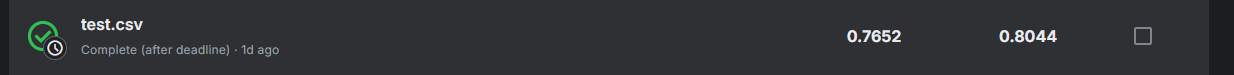

### 4.
| Trial      | Train Acc | Test Auc | Arch/Hyperparams                                        | Analysis                                                                                                                                                                    |
|------------|-----------|----------|---------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| T1         | .9557     | .6953    | 1 Conv, 1 Dense, 1 output Dense                         | Severe overfitting, memorization.                                                                                                                                           |
| T2         | .8175     | .7480    | Added second Conv block, L2(.001)                       | More depth along with L2 caused significant reduction in the gap between train and test sets                                                                                |
| T3         | .8144     | .7453    | Added early stop along with LR control                  | Didn't translate to direct accuracy increases but made training more informed with the addition of val-accuracy and allowed the epoch amount to be automatically controlled |
| T4         | .7915     | .7588    | Added extra Conv to each block                          | More depth allows the models to learn more features and gave better generalization                                                                                          |
| Final / T5 | .8195     | .7652    | Added second Dense Layer and adjusted sizes to 256, 128 | Adding more capacity for the classification allowed the model to better process the extra features extracted by the VGG blocks.                                             |

I wanted to make my layers wider, as well as add more layers for more depth but the TF version I had to use was having a ton of errors past a certain size of model or size of data. This architecture that I ended with could probably be improved with simply larger layers, and more depth. One addition that I attempted to make was data augmentation, by flipping and rotating the images while training I could get much better generalization but the model ran so slow that training wasn't feasible. The addition of early stop allowed me to train with much more ease as well as see the effect that changes had on the validation set.

### 5.
In the end I created a regularized VGG style CNN which achieved a test AUC score of .7652. I focused on minimizing the gap between my train score and the unseen test score. Methods that generally control overfitting in NN's were useful to improve my models test effectiveness. Having a larger model did slightly improve my model, but I ended up with basically the max size I could before TF started to have issues. Improvements that I could try in the future include, some type of upscaling of the images, I saw discussions of going as large as 216x216 from the target 32x32. This would allow for more data for our model, but the computational cost was already high with 220k images. In the same vain, I wanted to rotate and flip the images while training on them to help generalize, but it was extremely expensive, so I chose not to in the intrest of time.